In [1]:
import pandas as pd
import numpy as np
import torch
import joblib
from sklearn.ensemble import ExtraTreesRegressor
import matplotlib.pyplot as plt
from pathlib import Path

from cvae import CVAE
from generate import suggest

In [2]:
TARGET_YIELD = 1200.0   # MPa
N_SAMPLES = 50
DEVICE = torch.device("cpu")
OUT_DIR = Path("../outputs")
OUT_DIR.mkdir(exist_ok=True, parents=True)

In [3]:
scalers = joblib.load(
    "/Users/shrutisivakumar/Library/CloudStorage/OneDrive-Personal/College Stuff/"
    "Sem 5/Projects/DDMM/RHEA-Inverse-Design-Using-VAE/data/processed/scalers.joblib"
)
x_scaler = scalers["x_scaler"]
y_scaler = scalers["y_scaler"]
feature_cols = scalers["feature_cols"]

In [4]:
x_dim = len(feature_cols)
y_dim = 1

model = CVAE(x_dim=x_dim, y_dim=y_dim, z_dim=4, hidden=128).to(DEVICE)
model.load_state_dict(torch.load(
    "/Users/shrutisivakumar/Library/CloudStorage/OneDrive-Personal/College Stuff/"
    "Sem 5/Projects/DDMM/RHEA-Inverse-Design-Using-VAE/models/cvae_best.pt",
    map_location=DEVICE
))
model.eval()

CVAE(
  (enc): Encoder(
    (net_mu): MLP(
      (net): Sequential(
        (0): Linear(in_features=22, out_features=128, bias=True)
        (1): GELU(approximate='none')
        (2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (3): Linear(in_features=128, out_features=128, bias=True)
        (4): GELU(approximate='none')
        (5): Linear(in_features=128, out_features=4, bias=True)
      )
    )
    (net_logvar): MLP(
      (net): Sequential(
        (0): Linear(in_features=22, out_features=128, bias=True)
        (1): GELU(approximate='none')
        (2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (3): Linear(in_features=128, out_features=128, bias=True)
        (4): GELU(approximate='none')
        (5): Linear(in_features=128, out_features=4, bias=True)
      )
    )
  )
  (dec): DecoderStrongCond(
    (fc1): Linear(in_features=5, out_features=128, bias=True)
    (fc2): Linear(in_features=129, out_features=128, bias=True)
    (fc3): Linear(in_f

In [5]:
df_gen = suggest(
    model, x_scaler, y_scaler, feature_cols,
    y_target_scalar=TARGET_YIELD, N=N_SAMPLES, refine=True
)

# The CVAE’s property-head prediction is already included.
# Rename it so we can add a surrogate prediction alongside it.
if "Predicted_Yield_Strength" in df_gen.columns:
    df_gen.rename(columns={"Predicted_Yield_Strength": "Predicted_Yield_Strength_CVAE"}, inplace=True)

print(f"[INFO] Generated {len(df_gen)} candidates for target {TARGET_YIELD} MPa")

[INFO] Generated 50 candidates for target 1200.0 MPa


In [6]:
cat_cols = [
    "Equilibrium_Conditions_encoded",
    "Single_Multiphase_encoded",
    "Type_Present_Phases_encoded",
    "Tension_Compression_encoded",
]
for c in cat_cols:
    if c in df_gen.columns:
        df_gen[c] = df_gen[c].round().astype(int)

In [7]:
df_train = pd.read_csv("../data/encoded_data.csv")

# Build X/y for surrogate using EXACTLY the same feature_cols
X_train = df_train[feature_cols].copy()
y_train = df_train["Yield_Strength"].copy()

# Fill missing values
X_train = X_train.fillna(X_train.median(numeric_only=True))
y_train = y_train.fillna(y_train.median())

surrogate = ExtraTreesRegressor(n_estimators=500, random_state=42)
surrogate.fit(X_train, y_train)

ExtraTreesRegressor(n_estimators=500, random_state=42)

In [8]:
X_gen_for_surrogate = df_gen[feature_cols].copy()
X_gen_for_surrogate = X_gen_for_surrogate.fillna(X_train.median(numeric_only=True))

df_gen["Predicted_Yield_Strength_Surrogate"] = surrogate.predict(X_gen_for_surrogate)

In [9]:
raw_path = OUT_DIR / f"suggestions_y{int(TARGET_YIELD)}_raw.csv"
df_gen.to_csv(raw_path, index=False)
print(f"[INFO] Raw suggestions saved to {raw_path}")

[INFO] Raw suggestions saved to ../outputs/suggestions_y1200_raw.csv


In [10]:
df_ranked = df_gen.sort_values(by="Predicted_Yield_Strength_Surrogate", ascending=False).reset_index(drop=True)
ranked_path = OUT_DIR / f"suggestions_y{int(TARGET_YIELD)}_ranked.csv"
df_ranked.to_csv(ranked_path, index=False)
print(f"[INFO] Ranked suggestions saved to {ranked_path}")

[INFO] Ranked suggestions saved to ../outputs/suggestions_y1200_ranked.csv


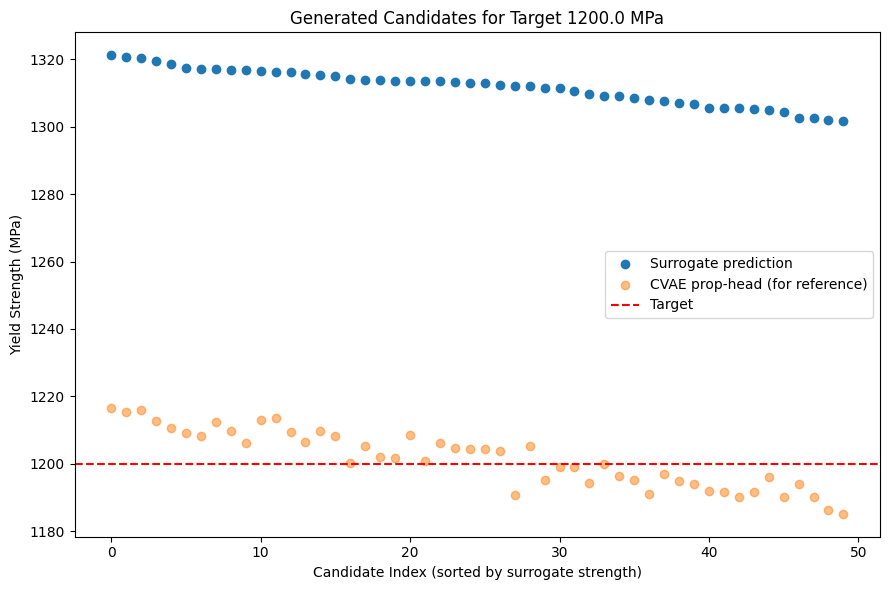

In [11]:
plt.figure(figsize=(9,6))
plt.scatter(
    range(len(df_ranked)),
    df_ranked["Predicted_Yield_Strength_Surrogate"],
    label="Surrogate prediction"
)
if "Predicted_Yield_Strength_CVAE" in df_ranked.columns:
    plt.scatter(
        range(len(df_ranked)),
        df_ranked["Predicted_Yield_Strength_CVAE"],
        alpha=0.5,
        label="CVAE prop-head (for reference)"
    )
plt.axhline(y=TARGET_YIELD, linestyle="--", label="Target", color="r")
plt.xlabel("Candidate Index (sorted by surrogate strength)")
plt.ylabel("Yield Strength (MPa)")
plt.title(f"Generated Candidates for Target {TARGET_YIELD} MPa")
plt.legend()
plot_path = OUT_DIR / f"yield_strength_plot_y{int(TARGET_YIELD)}.png"
plt.tight_layout()
plt.savefig(plot_path, dpi=300)
plt.show()

In [12]:
print("\n[Surrogate] Predicted_Yield_Strength summary:")
print(df_ranked["Predicted_Yield_Strength_Surrogate"].describe())

if "Predicted_Yield_Strength_CVAE" in df_ranked.columns:
    print("\n[CVAE] Predicted_Yield_Strength summary:")
    print(df_ranked["Predicted_Yield_Strength_CVAE"].describe())


[Surrogate] Predicted_Yield_Strength summary:
count      50.000000
mean     1311.863264
std         5.251608
min      1301.844600
25%      1307.810800
50%      1312.959800
75%      1316.053300
max      1321.206600
Name: Predicted_Yield_Strength_Surrogate, dtype: float64

[CVAE] Predicted_Yield_Strength summary:
count      50.000000
mean     1201.588257
std         8.494508
min      1185.167236
25%      1194.516571
50%      1201.976074
75%      1208.589050
max      1216.536377
Name: Predicted_Yield_Strength_CVAE, dtype: float64
